In [2]:
#Imports
import io
import os
import re
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from functools import reduce

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, optimizers, callbacks
import tensorflow_decision_forests as tfdf

#Notebook settings
default_max_columns = None
default_max_rows = 10
pd.set_option('display.max_columns', default_max_columns)
pd.set_option('display.max_rows', default_max_rows)

test_size_ratio = 0.2
val_size_ratio = 0.1

label_column = "Label"
batch_size = 512
num_datasets = 4
cwd = os.getcwd()

In [3]:
#Utility functions
def simplify_attack_labels(x):
    if x in ["DoS",
             "dos",
             "DoS attacks-Hulk",
             "DoS attacks-SlowHTTPTest",
             "DoS attacks-GoldenEye",
             "DoS attacks-Slowloris",
            ]:
        x = "DoS"

    elif x in ["DDoS",
               "ddos",
               "DDOS attack-HOIC",
               "DDOS attack-LOIC-UDP",
               "DDoS attacks-LOIC-HTTP",
              ]:
        x = "DDoS"

    elif x in ["Backdoor",
               "backdoor",
              ]:
        x = "Backdoor"
    elif x in ["xss",
               "Brute Force -XSS",
              ]:
        x = "XSS"
    elif x in ["mitm",
               "MITM",
              ]:
        x = "MITM"
    elif x in ["FTP-BruteForce",
               "SQL Injection",
              ]:
        pass
    else:
        x = x.lower()
        x = x[0].upper()+x[1:]
    return x

def frame_ip_to_octet(input_frame, ip_column, cleanup = True):
    frame = input_frame.copy()
    for i in range(4):
        frame[ip_column+"_octet"+str(i)] = frame[ip_column].apply(lambda x : ip_to_octet(x,i)).astype("float32")
    if cleanup:
        frame = frame.drop([ip_column],axis = 1)
    return frame

def ip_to_octets(ip_adress):
    if ip_adress == "?" or pd.isnull(ip_adress):
        return [replacement_number]*4
    octets = str(ip_adress).split(".")
    if len(octets) != 4:
        raise Exception("Invalid IP Adress: "+str(ip_adress))
    else:
        for i in range(0,3):
            octets[i] = int(octets[i])
        return octets

def ip_to_octet(ip_adress, octet_index):
    octets = ip_to_octets(ip_adress)
    return octets[octet_index]

protocol_dict = {"0":"HOPOPT",
                 "1":"ICMP",
                 "2":"IGMP",
                 "6":"TCP",
                 "17":"UDP",
                 "33":"DCCP",
                 "41":"IPv6",
                 "47":"GRE",
                 "53":"SWIPE",
                 "55":"TLSP",
                 "58":"IPv6-ICMP",
                 "77":"SUN-ND",
                 "89":"OSPFIGP",
                 "103":"PIM",
                 "132":"SCTP",
                 "2054":"ARP",
                 "35020":"LLDP",
                }

In [4]:
#Load data

df_list = []
file_paths = []

df_names = ["NF-UNSW-NB15","NF-CSE-CIC-IDS2018","NF-BoT-IoT","NF-ToN-IoT"]
file_paths.append("") #File paths deleted for privacy reasons
file_paths.append("")
file_paths.append("")
file_paths.append("")


for i in range(num_datasets):
    df_tmp = pd.read_csv(file_paths[i])
    df_list.append(df_tmp.copy())
    del df_tmp

In [5]:
df_list[0].head(5)

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,149.171.126.0,62073,59.166.0.5,56082,6,0.0,9672,416,11,8,25,15,0,Benign
1,149.171.126.2,32284,59.166.0.5,1526,6,0.0,1776,104,6,2,25,0,0,Benign
2,149.171.126.0,21,59.166.0.1,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign
3,59.166.0.1,23800,149.171.126.0,46893,6,0.0,528,8824,10,12,27,124,0,Benign
4,59.166.0.5,63062,149.171.126.2,21,6,1.0,1786,2340,32,34,25,1459,0,Benign


In [6]:
df_list[0].columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS',
       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack'],
      dtype='object')

In [7]:
#Cleaning

ip_regex = re.compile("\d+[.]\d+[.]\d+[.]\d+")

x=0

for i in range(num_datasets):
    df_list[i] = df_list[i].drop(["Attack"],axis=1)
    #Cleaning out unregular IP4 Adresses
    print(df_names[i]+"invalid IPV4 adresses count:")
    x = df_list[i].loc[(df_list[i]["IPV4_SRC_ADDR"].apply(lambda x: not(bool(ip_regex.match(x))))) | (df_list[i]["IPV4_DST_ADDR"].apply(lambda x: not(bool(ip_regex.match(x)))))].shape[0]
    print(x)
    print(x/df_list[i].shape[0])
    df_list[i] = df_list[i].drop(df_list[i].loc[(df_list[i]["IPV4_SRC_ADDR"].apply(lambda x: not(bool(ip_regex.match(x))))) | (df_list[i]["IPV4_DST_ADDR"].apply(lambda x: not(bool(ip_regex.match(x)))))].index)
    

NF-UNSW-NB15invalid IPV4 adresses count:
0
0.0
NF-CSE-CIC-IDS2018invalid IPV4 adresses count:
2
2.3831082428020302e-07
NF-BoT-IoTinvalid IPV4 adresses count:
0
0.0
NF-ToN-IoTinvalid IPV4 adresses count:
0
0.0


In [8]:
#Preprocessing for NF Datasets
for i in range(num_datasets):
    df_list[i]["PROTOCOL"] = df_list[i]["PROTOCOL"].apply(lambda x:  protocol_dict[str(x)] if str(x) in protocol_dict else "OTHER")
    df_list[i] = df_list[i].drop(["L7_PROTO","TCP_FLAGS"],axis = 1)

In [9]:
#Sideloading non NF datasets -> From now on iterate over num_datasets += 2
nf_cols = list(df_list[0].columns)
#nf_cols.remove("IPV4_SRC_ADDR")
#nf_cols.remove("L4_SRC_PORT")
#nf_cols.remove("IPV4_DST_ADDR")
#nf_cols.remove("L4_DST_PORT")
df_tmp = pd.read_csv("") #File paths deleted for privacy reasons
df_tmp = df_tmp[nf_cols]
df_names.append("X-IIoTiD")
df_list.append(df_tmp)
del df_tmp

df_tmp = pd.read_csv("") #File paths deleted for privacy reasons
df_tmp = df_tmp[nf_cols]
df_names.append("WUSTL-IIOT")
df_list.append(df_tmp)
del df_tmp

num_datasets = 6 # <----

for i in range(num_datasets):
    df_list[i] = df_list[i][nf_cols]

In [10]:
#Preprocessing for all datasets
for i in range(num_datasets):
    df_list[i] = frame_ip_to_octet(df_list[i],"IPV4_SRC_ADDR")
    df_list[i] = frame_ip_to_octet(df_list[i], "IPV4_DST_ADDR")  
    df_list[i] = pd.get_dummies(df_list[i], columns=["PROTOCOL"], dtype = "float")

In [11]:
df_list[0].head(5)

,L4_SRC_PORT,L4_DST_PORT,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,FLOW_DURATION_MILLISECONDS,Label,IPV4_SRC_ADDR_octet0,IPV4_SRC_ADDR_octet1,IPV4_SRC_ADDR_octet2,IPV4_SRC_ADDR_octet3,IPV4_DST_ADDR_octet0,IPV4_DST_ADDR_octet1,IPV4_DST_ADDR_octet2,IPV4_DST_ADDR_octet3,PROTOCOL_DCCP,PROTOCOL_GRE,PROTOCOL_HOPOPT,PROTOCOL_ICMP,PROTOCOL_IGMP,PROTOCOL_IPv6,PROTOCOL_OSPFIGP,PROTOCOL_OTHER,PROTOCOL_PIM,PROTOCOL_SCTP,PROTOCOL_SUN-ND,PROTOCOL_SWIPE,PROTOCOL_TCP,PROTOCOL_TLSP,PROTOCOL_UDP
0,62073,56082,9672,416,11,8,15,0,149.0,171.0,126.0,0.0,59.0,166.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,32284,1526,1776,104,6,2,0,0,149.0,171.0,126.0,2.0,59.0,166.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,21,21971,1842,1236,26,22,1111,0,149.0,171.0,126.0,0.0,59.0,166.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23800,46893,528,8824,10,12,124,0,59.0,166.0,0.0,1.0,149.0,171.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,63062,21,1786,2340,32,34,1459,0,59.0,166.0,0.0,5.0,149.0,171.0,126.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
#Alignment
big_frame = pd.DataFrame()
for df in df_list:
    big_frame, tmp = big_frame.align(df, join="outer", axis=1, fill_value = 0.0)
    del tmp

for i in range(num_datasets):
    df_list[i], tmp = df_list[i].align(big_frame, join="outer", fill_value = 0.0)
    del tmp

#Convert to float
for i in range(num_datasets):
    df_list[i] = df_list[i].astype("float32")

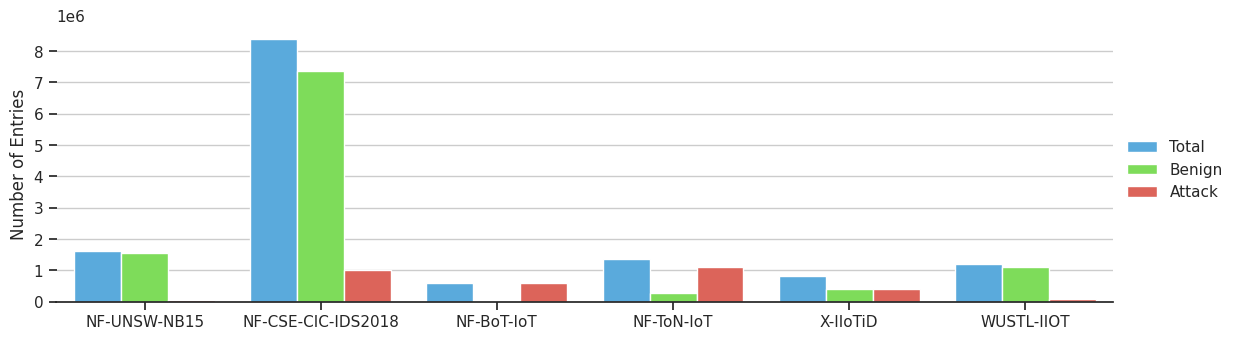

In [23]:
#Visualize Dataset Sizes
df = pd.DataFrame(columns=("NAME","SIZE","TYPE"))
for i in range(num_datasets):
    name = df_names[i]
    size = df_list[i].shape[0]
    attack_size = df_list[i].loc[df_list[i][label_column] == 1.0][label_column].count()
    benign_size = df_list[i].loc[df_list[i][label_column] == 0.0][label_column].count()
    df = pd.concat([df,pd.DataFrame({"NAME": name, "SIZE": size, "TYPE": "Total"}, index = [0])], ignore_index=True)
    df = pd.concat([df,pd.DataFrame({"NAME": name, "SIZE": benign_size, "TYPE": "Benign"}, index = [0])], ignore_index=True)
    df = pd.concat([df,pd.DataFrame({"NAME": name, "SIZE": attack_size, "TYPE": "Attack"}, index = [0])], ignore_index=True)

palette = ["#44aff2","#75f244","#f25244"]

g = sns.catplot(
    data=df, 
    kind="bar",
    palette=sns.color_palette(palette, len(palette)),
    x="NAME", y="SIZE", hue="TYPE", height=3.8, aspect = 3
)
g.despine(left=True)
g.set_axis_labels("", "Number of Entries")
g.legend.set_title("")    
plt.grid(axis="y")
plt.savefig("dataset_composition_figure.pdf", format='pdf')

In [13]:
pd.set_option('display.max_rows', 512)
df

,NAME,SIZE,TYPE
0,NF-UNSW-NB15,1623118,Total
1,NF-UNSW-NB15,1550712,Benign
2,NF-UNSW-NB15,72406,Attack
3,NF-CSE-CIC-IDS2018,8392399,Total
4,NF-CSE-CIC-IDS2018,7373196,Benign
5,NF-CSE-CIC-IDS2018,1019203,Attack
6,NF-BoT-IoT,600100,Total
7,NF-BoT-IoT,13859,Benign
8,NF-BoT-IoT,586241,Attack
9,NF-ToN-IoT,1379274,Total


In [14]:
pd.set_option('display.max_rows', default_max_rows)

In [15]:
df_list[5].columns

Index(['FLOW_DURATION_MILLISECONDS', 'IN_BYTES', 'IN_PKTS',
       'IPV4_DST_ADDR_octet0', 'IPV4_DST_ADDR_octet1', 'IPV4_DST_ADDR_octet2',
       'IPV4_DST_ADDR_octet3', 'IPV4_SRC_ADDR_octet0', 'IPV4_SRC_ADDR_octet1',
       'IPV4_SRC_ADDR_octet2', 'IPV4_SRC_ADDR_octet3', 'L4_DST_PORT',
       'L4_SRC_PORT', 'Label', 'OUT_BYTES', 'OUT_PKTS', 'PROTOCOL_ARP',
       'PROTOCOL_DCCP', 'PROTOCOL_GRE', 'PROTOCOL_HOPOPT', 'PROTOCOL_ICMP',
       'PROTOCOL_IGMP', 'PROTOCOL_IPv6', 'PROTOCOL_IPv6-ICMP',
       'PROTOCOL_OSPFIGP', 'PROTOCOL_OTHER', 'PROTOCOL_PIM', 'PROTOCOL_SCTP',
       'PROTOCOL_SUN-ND', 'PROTOCOL_SWIPE', 'PROTOCOL_TCP', 'PROTOCOL_TLSP',
       'PROTOCOL_UDP'],
      dtype='object')

In [16]:
df_list[5].head(5)

,FLOW_DURATION_MILLISECONDS,IN_BYTES,IN_PKTS,IPV4_DST_ADDR_octet0,IPV4_DST_ADDR_octet1,IPV4_DST_ADDR_octet2,IPV4_DST_ADDR_octet3,IPV4_SRC_ADDR_octet0,IPV4_SRC_ADDR_octet1,IPV4_SRC_ADDR_octet2,IPV4_SRC_ADDR_octet3,L4_DST_PORT,L4_SRC_PORT,Label,OUT_BYTES,OUT_PKTS,PROTOCOL_ARP,PROTOCOL_DCCP,PROTOCOL_GRE,PROTOCOL_HOPOPT,PROTOCOL_ICMP,PROTOCOL_IGMP,PROTOCOL_IPv6,PROTOCOL_IPv6-ICMP,PROTOCOL_OSPFIGP,PROTOCOL_OTHER,PROTOCOL_PIM,PROTOCOL_SCTP,PROTOCOL_SUN-ND,PROTOCOL_SWIPE,PROTOCOL_TCP,PROTOCOL_TLSP,PROTOCOL_UDP
0,0.053037,508.0,8.0,192.0,168.0,0.0,2.0,192.0,168.0,0.0,20.0,502.0,59034.0,0.0,644.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.052681,508.0,8.0,192.0,168.0,0.0,2.0,192.0,168.0,0.0,20.0,502.0,55841.0,0.0,644.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.051793,508.0,8.0,192.0,168.0,0.0,2.0,192.0,168.0,0.0,20.0,502.0,63774.0,0.0,644.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.889555,0.0,0.0,192.0,168.0,0.0,2.0,209.0,240.0,235.0,92.0,80.0,61771.0,1.0,248.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.500055,0.0,0.0,192.0,168.0,0.0,1.0,192.0,168.0,0.0,20.0,0.0,0.0,0.0,868.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#Training data formatting

df_train_list = []
df_test_list = []
df_val_list = []

for i in range(num_datasets):
    df_tmp, df_val = train_test_split(df_list[i], test_size  = val_size_ratio)
    df_train, df_test = train_test_split(df_list[i], test_size = test_size_ratio)
    del df_tmp
    
    
    df_train_list.append(df_train.copy())
    del df_train
    df_test_list.append(df_test.copy())
    del df_test
    df_val_list.append(df_val.copy())
    del df_val
    

In [18]:
#Export
for i in range(num_datasets):
    df_train_list[i].to_csv(cwd+"/datasets/"+df_names[i]+"_Trainset.csv",index=False)
    df_train_list[i] = df_train_list[i][:0]
    df_test_list[i].to_csv(cwd+"/datasets/"+df_names[i]+"_Testset.csv",index=False)
    df_test_list[i] = df_test_list[i][:0]
    df_val_list[i].to_csv(cwd+"/datasets/"+df_names[i]+"_Valset.csv",index=False)
    df_val_list[i] = df_val_list[i][:0]

del df_train_list 
del df_test_list
del df_val_list

In [19]:
#Normalize

df_list_n = df_list.copy()
del df_list

for i in range(num_datasets):
    df_list_n[i] = (df_list_n[i] - df_list_n[i].min()) / (df_list_n[i].max() - df_list_n[i].min()) 
    df_list_n[i] = df_list_n[i].fillna(0)


In [20]:
df_list_n[0]

,FLOW_DURATION_MILLISECONDS,IN_BYTES,IN_PKTS,IPV4_DST_ADDR_octet0,IPV4_DST_ADDR_octet1,IPV4_DST_ADDR_octet2,IPV4_DST_ADDR_octet3,IPV4_SRC_ADDR_octet0,IPV4_SRC_ADDR_octet1,IPV4_SRC_ADDR_octet2,IPV4_SRC_ADDR_octet3,L4_DST_PORT,L4_SRC_PORT,Label,OUT_BYTES,OUT_PKTS,PROTOCOL_ARP,PROTOCOL_DCCP,PROTOCOL_GRE,PROTOCOL_HOPOPT,PROTOCOL_ICMP,PROTOCOL_IGMP,PROTOCOL_IPv6,PROTOCOL_IPv6-ICMP,PROTOCOL_OSPFIGP,PROTOCOL_OTHER,PROTOCOL_PIM,PROTOCOL_SCTP,PROTOCOL_SUN-ND,PROTOCOL_SWIPE,PROTOCOL_TCP,PROTOCOL_TLSP,PROTOCOL_UDP
0,0.000003,0.000358,0.000499,0.228972,0.97076,0.000000,0.019608,0.763736,1.00000,0.522822,0.000000,0.855756,0.947173,0.0,0.000028,0.000726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.000000,0.000064,0.000250,0.228972,0.97076,0.000000,0.019608,0.763736,1.00000,0.522822,0.008230,0.023285,0.492622,0.0,0.000007,0.000181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000259,0.000067,0.001248,0.228972,0.97076,0.000000,0.003922,0.763736,1.00000,0.522822,0.000000,0.335256,0.000320,0.0,0.000084,0.001996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000029,0.000018,0.000449,0.649533,1.00000,0.522822,0.000000,0.269231,0.97076,0.000000,0.004115,0.715541,0.363165,0.0,0.000602,0.001089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000340,0.000065,0.001547,0.649533,1.00000,0.522822,0.007843,0.269231,0.97076,0.000000,0.020576,0.000320,0.962264,0.0,0.000160,0.003084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623113,0.000000,0.000003,0.000050,0.649533,1.00000,0.522822,0.031373,0.269231,0.97076,0.000000,0.008230,0.000809,0.025025,0.0,0.000011,0.000181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1623114,0.000000,0.000074,0.001747,0.649533,1.00000,0.522822,0.023529,0.269231,0.97076,0.000000,0.008230,0.000320,0.055085,0.0,0.000164,0.003084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1623115,0.000000,0.000010,0.000250,0.649533,1.00000,0.522822,0.023529,0.269231,0.97076,0.000000,0.008230,0.621424,0.071214,0.0,0.000131,0.000726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1623116,0.000000,0.000018,0.000449,0.649533,1.00000,0.522822,0.023529,0.269231,0.97076,0.000000,0.008230,0.858213,0.086076,0.0,0.000602,0.001089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
#Normalized training data formatting

df_train_n_list = []
df_test_n_list = []
df_val_n_list = []

for i in range(num_datasets):
    df_temp, df_val_n = train_test_split(df_list_n[i], test_size = val_size_ratio)
    del df_temp
    df_train_n, df_test_n = train_test_split(df_list_n[i], test_size = test_size_ratio)
    
    
    
    df_train_n_list.append(df_train_n.copy())
    del df_train_n
    df_test_n_list.append(df_test_n.copy())
    del df_test_n
    df_val_n_list.append(df_val_n.copy())
    del df_val_n

In [22]:
#Export of normalized dataframes
for i in range(num_datasets):
    df_train_n_list[i].to_csv(cwd+"/normalized_datasets/"+df_names[i]+"_n_Trainset.csv",index=False)
    df_train_n_list[i] = df_train_n_list[i][:0]
    df_test_n_list[i].to_csv(cwd+"/normalized_datasets/"+df_names[i]+"_n_Testset.csv",index=False)
    df_test_n_list[i] = df_test_n_list[i][:0]
    df_val_n_list[i].to_csv(cwd+"/normalized_datasets/"+df_names[i]+"_n_Valset.csv",index=False)
    df_val_n_list[i] = df_val_n_list[i][:0]

del df_train_n_list 
del df_test_n_list
del df_val_n_list

In [23]:
print(df_names)

['NF-UNSW-NB15', 'NF-CSE-CIC-IDS2018', 'NF-BoT-IoT', 'NF-ToN-IoT', 'X-IIoTiD', 'WUSTL-IIOT']
